<a href="https://colab.research.google.com/github/andrade-adsf/data_science_bootcamp/blob/main/uti_sirio_libanes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prevendo a quantidade de leitos de UTI necessários para tratamento.


---

Os dados utilizados nesse notebook foram disponibilizados pelo Hospital Sírio Libanês (São Paulo e Brasília) através do [Kaggle](https://https://www.kaggle.com/S%C3%ADrio-Libanes/covid19).

Dados reais e adaptados para dificultar identificação dos pacientes respeitando a privacidade de cada um.


##Introdução

No último ano o Brasil e o mundo vem enfrentando uma das maiores batalhas já travada na história da humanidade, dessa vez contra um vírus que ao redor do mundo já tirou a vida de mais de 3 milhões de pessoas, deixando milhares de famílias desamparadas.

Os profissionais que trabalham em hospitais tem sido heróis das nações e enfrentado desafios diferentes todos os dias, dentre eles está a incerteza de capacidade hospitalar para todos os doentes. Tendo isso em vista vamos construir um modelo que visa auxiliar o trabalho dos médicos e enfermeiros fazendo a predição de necessidade de UTI para cada paciente que chega ao hospital, ajudando no planejamento de leitos.

##Importando libraries e dados

Para análise e manipulação dos dados vamos utilizar algumas bibliotecas já conhecidas por profissionais de ciência de dados.

In [ ]:
#bibliotecas de manipulação de dados
import pandas as pd
import numpy as np

#bibliotecas de plotagem de gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import plot_confusion_matrix

#bibilotecas de feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit#train/test data split

#bibliotecas de ML
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#bibliotecas de metricas de ML
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

#setando o estilo gráfico utilizado nas análises
sns.set()

#salvando o caminho e carregando os dados
path = "https://github.com/andrade-adsf/data_science_bootcamp/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true"
df = pd.read_excel(path)

##Definindo funções

Vou agrupar as funções que vamos criar aqui nessa parte para melhorar a leitura do projeto e facilitar nosso trabalho.

In [ ]:
def fill_na(data):
  '''
  Preenche os valores faltantes dentro do dataset
    
    Parametros:
      data (dataframe): Dataframe do pandas

    Retorna:
      df_filled (dataframe): Datafrrame do pandas com os valores preenchidos
  '''
  na_columns = data.iloc[:, 13:-2].columns
  continuos_features_filled = data.groupby("patient_visit_identifier", as_index=False)[na_columns].fillna(method="bfill").fillna(method="ffill")
  categorical_features = data.iloc[:, :13]
  y = data.iloc[:, -2:]
  df_filled = pd.concat([categorical_features, continuos_features_filled, y], ignore_index=True, axis=1)
  df_filled.columns = data.columns
  return df_filled

In [ ]:
def prepare_window(rows):
  '''
  Localiza as linhas da primeira janela de tempo e preeche icu como positivo nessa linha caso o paciente tenha ido à UTI.
    
    Parametros:
      rows (dataframe): Dataframe do pandas

    Retorna:
      rows (dataframe): Dataframe filtrado com apenas a primeira janela
  '''
  if np.any(rows["icu"]):
    rows.loc[rows["window"]==0, "icu"] = 1
  return rows.loc[rows["window"]==0]


In [ ]:
def del_corr_feat(data, threshold, plot=False):
   '''
  Deleta features com alta correelação, também pode mostrar o heatmap de correlaçã
    
    Parametros:
      data (dataframe): Dataframe do pandas
      threshold (float): Limite máximo de correlação
      plot (bool): Define se o heatmap será plotado, default=False

    Retorna:
      data (dataframe): Datafram sem as features com alta correlação
  '''
  df_corr = data.iloc[:, 4:-2].corr().abs()
  df_corr = df_corr.where(np.tril(np.ones(df_corr.shape).astype(np.bool), k=-1).astype(np.bool))
  delete = [coluna for coluna in df_corr.columns if any(df_corr[coluna] > threshold)]
  if plot:
    plt.figure(figsize=(8,8))
    ax = sns.heatmap(df_corr, cmap="coolwarm", square=True, linecolor='white')
    plt.title("""Sírio Libanês
  Correlação dos dados de UTI por COVID-19""", fontsize=16, fontweight="bold")

  return data.drop(delete, axis=1)

In [ ]:
def classify_model(model, n_estimators, max_depth, x, y, result_table):
   '''
  Imprime o Classification Report do modelo escolhido
    
    Parametros:
      model (function): Modelo a ser utilizado para previsão
      n_estimators (int): n_estimators usado no modelo
      max_depth (int): max_depth usado no modelo
      x (dataframe): valores de x
      y (dataframe): valores de y
      result_table (dataframe): Dataframe com colunas necessárias para plotar Matriz de confusão

    Retorna:
      y_test (list): y de teste
      y_predict (list): y previsto no teste
      result_table (dataframe): Dataframe atualizada com os valores do modelo
  '''
  modelo = model(n_estimators=n_estimators, max_depth=max_depth)

  X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y)
  modelo.fit(X_train, y_train)

  y_score = modelo.predict_proba(X_test)[:,1]
  y_predict = modelo.predict(X_test)

  fpr, tpr, _ = roc_curve(y_test, y_score)
  auc = roc_auc_score(y_test, y_score)

  result_table = result_table.append({'classifiers':modelo.__class__.__name__,
                                      'fpr':fpr,
                                      'tpr':tpr,
                                      'auc':auc}, ignore_index=True)

  print(classification_report(y_test, y_predict, zero_division=0))

  return y_test, y_predict, result_table

In [ ]:
def plot_cf_matrix(y_test, y_predict, title, xlabel, ylabel, cbar=False):
   '''
  Plota matrix de confusão
    
    Parametros:
      y_test (dataframe): y de teste
      y_predict (dataframe): y previsto
      title (str): Titulo do gráfico
      xlabel (str): Legenda do eixo x
      ylabel (str): Legenda do eixo y
      cbar (bool): Legenda de cor ativo ou desativado
  '''
  #confusion matrix
  cf_matrix = confusion_matrix(y_test, y_predict)

  #plot and figure size
  plt.figure(figsize=(6,6))#figure size
  ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='icefire', square=True, linecolor='white', linewidths=1, cbar=cbar)#plot

  #chart setting
  plt.title(title, fontsize=16, fontweight='bold')
  ax.set_xlabel(xlabel, fontsize=14)
  ax.set_ylabel(ylabel, fontsize=14)

  #show chart
  plt.show()

##Conhecendo nossos dados

Afim de conhecer melhor com o que estamos trabalhando vamos explorar as primeiras entradas de dados.

A parte de investigação é importante para garantirmos que nossos dados não estão enviesados e para conhecermos as histórias que nossos dados estão nos contando.

In [ ]:
df.head()#mostrar 5 primeiras entradas do dataset

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

Com essa primeira visualização já foi possível observar alguns dados faltantes e um padrão de nomenclatura não muito comum, mais pra frente vamos alterar esse padrão para maior facilidade na manipulação dos dados.

Além disso também vamos verificar o número de variáveis e entradas e os tipos de dados.

In [ ]:
df.info()#mostrar tipos e quantidade de variáveis e entradas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


###Sumário

Temos 1925 entradas para 231 variáveis. São muitas váriavies e por isso vamos fazer um dicionário com apenas as cujos nomes não são tão descritivos.

---

`patient_visit_identifier` - ID de visita do paciente, caso seja feita mais de uma visita será disponibilizado um novo ID para cada uma delas.

`disease_group_n` - Grupo de doenças pré existentes.

`window` - Janela de tempo após a chegada do paciente ao hospital em que os dados foram medidos.

`icu` - Indica se o paciente está na UTI ou não.

###Verificando os dados nulos

Já vimos que temos alguns dados nulos, agora vamos verificar a porcentagem desses dados que estão faltando. Por conta do tamanho do dataset vamos verificar apenas algumas colunas mas em ordem decrescente para saber o máximo de dados faltantes.

In [ ]:
(df.isna().sum() / df.shape[0]).sort_values(ascending=False)#mostrar porcentagem de dados faltantes

P02_VENOUS_MIN              0.573506
HEMOGLOBIN_MEAN             0.573506
LACTATE_MIN                 0.573506
LACTATE_MEAN                0.573506
LACTATE_MEDIAN              0.573506
                              ...   
AGE_ABOVE65                 0.000000
ICU                         0.000000
GENDER                      0.000000
WINDOW                      0.000000
PATIENT_VISIT_IDENTIFIER    0.000000
Length: 231, dtype: float64

Então as 5 colunas com mais dados faltantes tem 57% dos dados perdidos. No kaggle, onde os dados foram disponibilizados, os profissionais do Hospital Sírio Libanês deixaram uma anotação sobre isso, vamos ver o que eles dizem.

> Problema: Um dos maiores desafios de trabalhar com dados de saúde é que as taxas de amostragem variam entre diferentes tipos de medição. Por exemplo, sinais vitais são colhidos mais frequentemente (geralmente de hora em hora) do que exames de sangue (geralmente diariamente).

> Dicas e Truques: É razoal assumir que um paciente que não teve uma amostra registrada em um período de tempo está com a saúde estável, potencialmente apresentando sinais vitais e exame sanguíneos similar à janelas de tempo anteriores ou posteriores. Portanto pode-se preencher os valores faltantes usando as entradas anteriores ou posteriores.

*Tradução livre, para consultar o texto original visite a página do desafio no kaggle.*



###Descrição dos dados

Por ultimo mas não menos importante, vamos dar uma olhada na descrição dos nosso dados a partir da função `describe`. Essa função nos mostrará alguns dados estatísticos de todos os dados númericos.

In [ ]:
df.describe()#mostra dados estatisticos dos dados númericos

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,...,821.000000,821.000000,821.0,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,0.158333,0.809896,0.528527,0.528527,0.528527,0.528527,-1.0,-0.963433,-0.963433,-0.963433,-0.963433,-1.0,-0.931121,-0.931121,-0.931121,-0.931121,-1.0,-0.310924,-0.310924,-0.310924,-0.310924,-1.0,-0.311845,-0.311845,-0.311845,-0.311845,-1.0,-0.945928,-0.945928,-0.945928,...,-0.954177,-0.954177,-1.0,-0.093631,-0.332600,-0.264701,-0.438754,0.066893,0.743077,-0.097790,-0.338468,-0.268632,-0.435121,0.063798,0.748588,-0.040855,-0.207812,-0.264999,-0.483129,0.326823,0.817565,-0.235001,-0.399582,-0.282029,-0.316753,0.014964,0.818593,-0.752454,-0.728053,-0.754100,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,0.365148,0.392485,0.224100,0.224100,0.224100,0.224100,0.0,0.160870,0.160870,0.160870,0.160870,0.0,0.169509,0.169509,0.169509,0.169509,0.0,0.100256,0.100256,0.100256,0.100256,0.0,0.118812,0.118812,0.118812,0.118812,0.0,0.076610,0.076610,0.076610,...,0.123582,0.123582,0.0,0.252064,0.274102,0.246760,0.217113,0.242858,0.132635,0.257733,0.277952,0.252709,0.225554,0.249208,0.125994,0.281304,0.277802,0.272725,0.278239,0.216198,0.283453,0.271123,0.287580,0.296247,0.402675,0.276163,0.141316,0.364001,0.408677,0.366349,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000

Somente duas variáveis ficaram de fora do describe, são elas, `age_percentil` e `window`. Já sabemos que o nossos modelos de Machine Learning usarão somente variáveis númericas para realizar a previsão dos casos, então durante o tratamento dos dados vamos precisar arrumar alguma estratégia para transformar esses dados em númericos.

##Tratamento dos dados

Primeiramente vou ajustar o nome das colunas para facilitar nosso trabalho.

In [ ]:
#Substituindo espaços por underscores e alterando para caixa baixa
df.columns = df.columns.str.replace(' ','_')#substitui espaço por underscore
df.columns = df.columns.str.lower()#transforma o nome das colunas em letras minusculas

df.head(3)#mostrando o resultado

,patient_visit_identifier,age_above65,age_percentil,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other,albumin_median,albumin_mean,albumin_min,albumin_max,albumin_diff,be_arterial_median,be_arterial_mean,be_arterial_min,be_arterial_max,be_arterial_diff,be_venous_median,be_venous_mean,be_venous_min,be_venous_max,be_venous_diff,bic_arterial_median,bic_arterial_mean,bic_arterial_min,bic_arterial_max,bic_arterial_diff,bic_venous_median,bic_venous_mean,bic_venous_min,bic_venous_max,bic_venous_diff,billirubin_median,billirubin_mean,...,dimer_max,dimer_diff,bloodpressure_diastolic_mean,bloodpressure_sistolic_mean,heart_rate_mean,respiratory_rate_mean,temperature_mean,oxygen_saturation_mean,bloodpressure_diastolic_median,bloodpressure_sistolic_median,heart_rate_median,respiratory_rate_median,temperature_median,oxygen_saturation_median,bloodpressure_diastolic_min,bloodpressure_sistolic_min,heart_rate_min,respiratory_rate_min,temperature_min,oxygen_saturation_min,bloodpressure_diastolic_max,bloodpressure_sistolic_max,heart_rate_max,respiratory_rate_max,temperature_max,oxygen_saturation_max,bloodpressure_diastolic_diff,bloodpressure_sistolic_diff,heart_rate_diff,respiratory_rate_diff,temperature_diff,oxygen_saturation_diff,bloodpressure_diastolic_diff_rel,bloodpressure_sistolic_diff_rel,heart_rate_diff_rel,respiratory_rate_diff_rel,temperature_diff_rel,oxygen_saturation_diff_rel,window,icu
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.59322,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0,-0.162393,-0.5,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.59322,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0,-0.025641,-0.5,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0


Agora vamos transformar nossas colunas cujos dtypes são object, primeiro só para ter certeza vamos selecionar apenas essas colunas para verificar.

In [ ]:
df.select_dtypes(include="object").columns#Seleciona as colunas cujo dtype são object

Index(['age_percentil', 'window'], dtype='object')

In [ ]:
df.age_percentil = df.age_percentil.astype("category").cat.codes#transforma em variável categórica
df.age_percentil#mostra os dados atualizados

0       5
1       5
2       5
3       5
4       5
       ..
1920    4
1921    4
1922    4
1923    4
1924    4
Name: age_percentil, Length: 1925, dtype: int8

In [ ]:
df.window = df.window.astype("category").cat.codes#transforma em variável categórica
df.window#mostra os dados atualizados

0       0
1       1
2       2
3       3
4       4
       ..
1920    0
1921    1
1922    2
1923    3
1924    4
Name: window, Length: 1925, dtype: int8

###Tratando os dados nulos

Vamos separar as colunas que possuem dados nulos em uma só variável. Essas colunas são as relacionadas a medição das condições de saúde feitas no paciente e começam na decima terceira coluna e vão até a coluna window.

Depois disso vamos preencher as linhas faltantes com os dados do periodo de tempo anterior ou posterior, ja que essas medições não costumam ter variações muito altas entre elas.

In [ ]:
df_filled = fill_na(df)#preenche as colunas com dados nulos usando a função criada mais cedo
df_filled#mostra os dados preenchidos

,patient_visit_identifier,age_above65,age_percentil,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other,albumin_median,albumin_mean,albumin_min,albumin_max,albumin_diff,be_arterial_median,be_arterial_mean,be_arterial_min,be_arterial_max,be_arterial_diff,be_venous_median,be_venous_mean,be_venous_min,be_venous_max,be_venous_diff,bic_arterial_median,bic_arterial_mean,bic_arterial_min,bic_arterial_max,bic_arterial_diff,bic_venous_median,bic_venous_mean,bic_venous_min,bic_venous_max,bic_venous_diff,billirubin_median,billirubin_mean,...,dimer_max,dimer_diff,bloodpressure_diastolic_mean,bloodpressure_sistolic_mean,heart_rate_mean,respiratory_rate_mean,temperature_mean,oxygen_saturation_mean,bloodpressure_diastolic_median,bloodpressure_sistolic_median,heart_rate_median,respiratory_rate_median,temperature_median,oxygen_saturation_median,bloodpressure_diastolic_min,bloodpressure_sistolic_min,heart_rate_min,respiratory_rate_min,temperature_min,oxygen_saturation_min,bloodpressure_diastolic_max,bloodpressure_sistolic_max,heart_rate_max,respiratory_rate_max,temperature_max,oxygen_saturation_max,bloodpressure_diastolic_diff,bloodpressure_sistolic_diff,heart_rate_diff,respiratory_rate_diff,temperature_diff,oxygen_saturation_diff,bloodpressure_diastolic_diff_rel,bloodpressure_sistolic_diff_rel,heart_rate_diff_rel,respiratory_rate_diff_rel,temperature_diff_rel,oxygen_saturation_diff_rel,window,icu
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0
1,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1,0
2,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.339130,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,2,0
3,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.7

Vamos verificar se ainda existe algum dado nulo no dataset.

In [ ]:
df_filled.isna().sum().sort_values(ascending=False)#mostra colunas com mais valores nulos em ordem decrescente

htn                         5
disease_grouping_1          5
disease_grouping_2          5
disease_grouping_3          5
disease_grouping_4          5
                           ..
potassium_mean              0
potassium_median            0
platelets_diff              0
platelets_max               0
patient_visit_identifier    0
Length: 231, dtype: int64

Considerando o método que utilizamos para fazer o preenchimento dos dados, os casos de nulos que temos agora devem ser de pacientes que não tiveram nenhum registro em toda sua passagem pelo hospital, por esse motivo vamos excluir essas linhas.

In [ ]:
df_clean = df_filled.dropna()#removendo as linhas que ainda possuem valores nulos
df_clean.isna().sum().sort_values(ascending=False)#mostrando novamente a quantidade de nulos em ordem crescente

icu                         0
inr_min                     0
inr_median                  0
hemoglobin_diff             0
hemoglobin_max              0
                           ..
potassium_mean              0
potassium_median            0
platelets_diff              0
platelets_max               0
patient_visit_identifier    0
Length: 231, dtype: int64

E vamos verificar quantos pacientes temos no dataframe.

In [ ]:
print("Quantidade de pacientes:\t{}".format(df_clean["patient_visit_identifier"].nunique()))#mostra a quantidade de pacientes no dataset

Quantidade de pacientes:	384


Pronto, feito isso ainda precisamos definir uma estratégia para usar na coluna `window`.

Vamos apenas verificar se o paciente foi para a UTI em alguma das janelas de tempo observadas, vamos apenas colocar essa informação na primeira janela de tempo e descartar as demais.

Assim podemos prever com maior velocidade se o paciente foi para a UTI ou não.

###Mas por que descartar os dados da linha em que o paciente foi para a UTI?

Estamos analisando dados referentes a paciente em certas janelas de horas que ele esteve no hospital, certo? Mas não temos como saber dentro dessa janela de horas se a medição registrada foi coletada antes ou depois do paciente ir pra UTI, e além disso o registro de um paciente que já está na UTI não faz sentido para a previsão proposta.

Por esse motivo vamos apagar também dos nossos dados todos os pacientes que foram para a UTI na primeira janela de tempo.

In [ ]:
#cria uma lista com os pacientes que tenham janela 0-2 com positivo para UTI
window_one_uci_patient = df_clean.query("window==0 and icu==1")["patient_visit_identifier"].values
window_one_uci_patient

array([  1,  17,  27,  41,  47,  48,  54,  62,  85,  90, 104, 106, 109,
       117, 144, 176, 202, 206, 226, 233, 239, 261, 270, 282, 286, 306,
       315, 329, 359, 362, 366, 379])

In [ ]:
df_clean = df_clean.query("patient_visit_identifier not in @window_one_uci_patient") #tira os pacientes selecionados acima do dataset
print("Quantidade de pacientes:\t{}".format(df_clean.patient_visit_identifier.nunique()))#mostra a quantidade de pacientes atualizada

Quantidade de pacientes:	352


###Lidando com a coluna `window`

Chegou a hora de deixarmos apenas a primeira janela para cada paciente.

In [ ]:
df_clean.groupby("patient_visit_identifier").apply(prepare_window)#aplica a função prepare_window aos dados tratados

,,patient_visit_identifier,age_above65,age_percentil,gender,disease_grouping_1,disease_grouping_2,disease_grouping_3,disease_grouping_4,disease_grouping_5,disease_grouping_6,htn,immunocompromised,other,albumin_median,albumin_mean,albumin_min,albumin_max,albumin_diff,be_arterial_median,be_arterial_mean,be_arterial_min,be_arterial_max,be_arterial_diff,be_venous_median,be_venous_mean,be_venous_min,be_venous_max,be_venous_diff,bic_arterial_median,bic_arterial_mean,bic_arterial_min,bic_arterial_max,bic_arterial_diff,bic_venous_median,bic_venous_mean,bic_venous_min,bic_venous_max,bic_venous_diff,billirubin_median,billirubin_mean,...,dimer_max,dimer_diff,bloodpressure_diastolic_mean,bloodpressure_sistolic_mean,heart_rate_mean,respiratory_rate_mean,temperature_mean,oxygen_saturation_mean,bloodpressure_diastolic_median,bloodpressure_sistolic_median,heart_rate_median,respiratory_rate_median,temperature_median,oxygen_saturation_median,bloodpressure_diastolic_min,bloodpressure_sistolic_min,heart_rate_min,respiratory_rate_min,temperature_min,oxygen_saturation_min,bloodpressure_diastolic_max,bloodpressure_sistolic_max,heart_rate_max,respiratory_rate_max,temperature_max,oxygen_saturation_max,bloodpressure_diastolic_diff,bloodpressure_sistolic_diff,heart_rate_diff,respiratory_rate_diff,temperature_diff,oxygen_saturation_diff,bloodpressure_diastolic_diff_rel,bloodpressure_sistolic_diff_rel,heart_rate_diff_rel,respiratory_rate_diff_rel,temperature_diff_rel,oxygen_saturation_diff_rel,window,icu
patient_visit_identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.07692

Agora nosso número de linhas é igual ao nosso número de pacientes, ou seja, uma linha por paciente.

##Definindo as features

Precisamos definir quais são as colunas mais relevantes para nosso algoritmo de ML fazer as previsões.

Geralmente dados com correlações muito altas levam à um overfiting, por isso a primeira coisa que vamos fazer é remover esses dados.

Para isso eu criei dois tresholds, um que vai excluir colunas com mais de 0.85 de correlação e outro de 0.95, vamos testar ambos e observar com qual temos melhor resultado.

Além disso também vou plotar a matriz de correlação antes das colunas serem excluidas para termos uma ideia do que está acontecendo por trás dos panos.

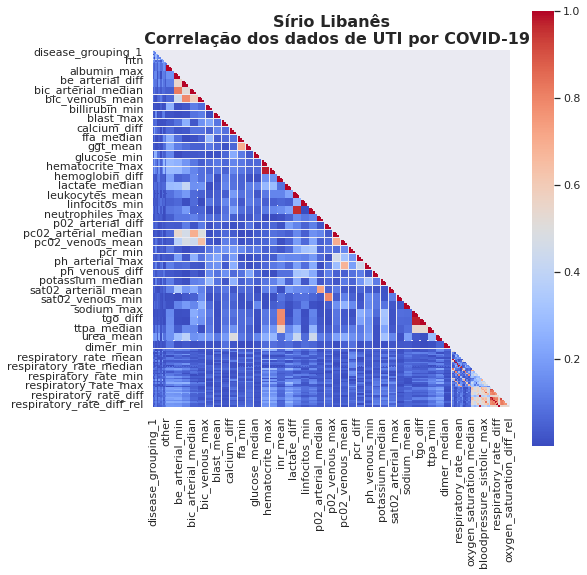

In [ ]:
df_wo_corr085 = del_corr_feat(df_clean, 0.85)#a partir da função del_corr_feat deleta as colunas com mais de 0.85 de correlação
df_wo_corr095 = del_corr_feat(df_clean, 0.95, True)#mesma coisa que a de cima porém para 0.95 de correlação e mostra o gráfico de correlação

##Testando alguns modelos de ML

Para treinar e testar esses dados vamos precisar separa-los entre *x*, dados que o algoritmo recebe, e *y*, dados que o algoritmo prevê, como vamos fazer testes com trasholds diferentes separei dois *x* diferentes.

In [ ]:
x085 = df_wo_corr085.drop(["patient_visit_identifier", "icu", "window"], axis=1)#separa x para correlação 0.85
x095 = df_wo_corr095.drop(["patient_visit_identifier", "icu", "window"], axis=1)#separa x para correlação 0.95
y = df_wo_corr095["icu"]#separa y

Agora sim vamos rodar com alguns modelos, verificar o score que atingimos e a partir disso definir qual o melhor modelo para o nosso caso.

In [ ]:
features = [x085, x095] #lista com os x
models = [
      DummyClassifier,
      LogisticRegression,
      DecisionTreeClassifier,
      RandomForestClassifier,
      ExtraTreesClassifier] #lista com modelos a serem usados
position = 0 #para saber qual x esta sendo utilizado

for x in features: #roda cada um dos modelos para ambos os x
  if position == 0:
    print("Resultados para threshold de correlação igual à 0.85:")
    position +=1
  else:
    print("\nResultados para threshold de correlação igual à 0.95:")
  for model in models:
      
      if model.__name__ == 'DummyClassifier':
        modelo = model(strategy='stratified')
      elif model.__name__ == 'LogisticRegression':
        modelo = model(solver='lbfgs', max_iter=1000)
      elif model.__name__ == 'DecisionTreeClassifier':
        modelo = model(max_depth=10)
      elif model.__name__ == 'RandomForestClassifier':
        modelo = model(n_estimators=200, max_depth=10)
      elif model.__name__ == 'ExtraTreesClassifier':
        modelo = model(n_estimators=200, max_depth=10)
      else:
          modelo = model()

      cv = StratifiedShuffleSplit(n_splits=10)
      score = cross_val_score(modelo, x, y, scoring='roc_auc', cv=cv)
      
      print(f'{model.__name__:22} AUC: {score.mean():.3f} STD: {score.std():.2f}')

Resultados para threshold de correlação igual à 0.85:
DummyClassifier        AUC: 0.521 STD: 0.04
LogisticRegression     AUC: 0.877 STD: 0.01
DecisionTreeClassifier AUC: 0.768 STD: 0.06
RandomForestClassifier AUC: 0.931 STD: 0.02
ExtraTreesClassifier   AUC: 0.912 STD: 0.02

Resultados para threshold de correlação igual à 0.95:
DummyClassifier        AUC: 0.480 STD: 0.02
LogisticRegression     AUC: 0.888 STD: 0.02
DecisionTreeClassifier AUC: 0.727 STD: 0.07
RandomForestClassifier AUC: 0.927 STD: 0.02
ExtraTreesClassifier   AUC: 0.908 STD: 0.02


Vimos então que os melhores modelos são o ExtraTreesClassifier e o RandomForestClassifier e que ambos obtiveram melhor resultado com o treshold de correlação em 0.95. Então a partir daqui vamos utilizar apenas esse treshold.

In [ ]:
x = x095#define x como threshold 0.95

##Verificando os resultados obtidos com esses modelos

Agora fiz algumas mudanças nos hiperparametros afim de obter melhor desempenho com os modelos, vamos verificar os resultados com o Classification Report e depois plotar a matriz de confusão e a ROC Curve.

###Random Forest Classifier

In [ ]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc'])#cria result_table

y_test, y_predict, result_table = classify_model(model=RandomForestClassifier, n_estimators=130, max_depth=10, x=x, y=y, result_table=result_table)

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       351
           1       0.80      0.49      0.61        89

    accuracy                           0.87       440
   macro avg       0.84      0.73      0.77       440
weighted avg       0.87      0.87      0.86       440



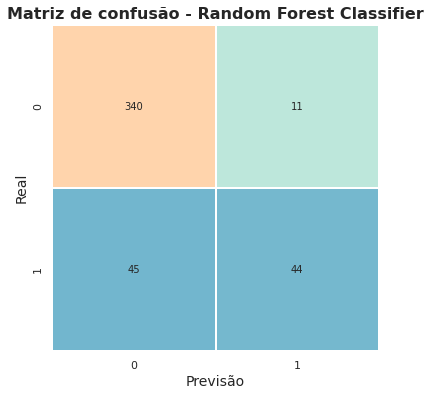

In [ ]:
title = 'Matriz de confusão - Random Forest Classifier'
xlabel = 'Previsão'
ylabel = 'Real'
plot_cf_matrix(y_test, y_predict, title, xlabel, ylabel)

###Extra Trees Classifier

In [ ]:
y_test, y_predict, result_table = classify_model(model=ExtraTreesClassifier, n_estimators=150, max_depth=5, x=x, y=y, result_table=result_table)
result_table.set_index('classifiers', inplace=True)#seta index

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       351
           1       0.94      0.37      0.53        89

    accuracy                           0.87       440
   macro avg       0.90      0.68      0.73       440
weighted avg       0.88      0.87      0.84       440



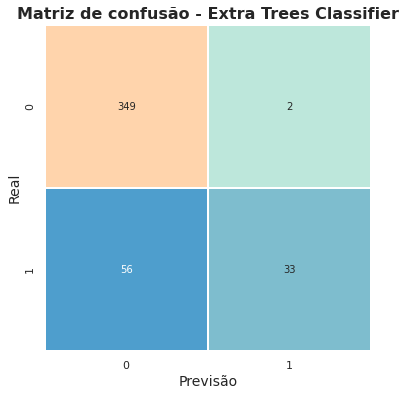

In [ ]:
title = 'Matriz de confusão - Extra Trees Classifier'
xlabel = 'Previsão'
ylabel = 'Real'
plot_cf_matrix(y_test, y_predict, title, xlabel, ylabel)

###Roc Curve

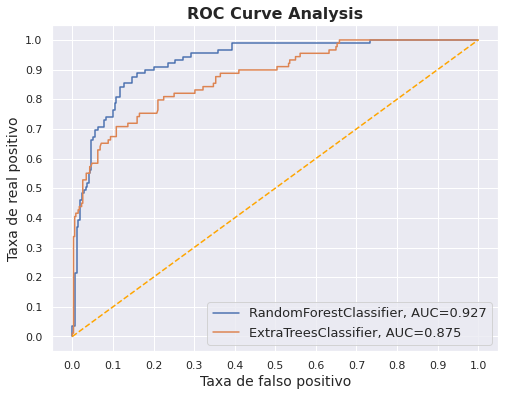

In [ ]:
fig = plt.figure(figsize=(8,6))#plota a figura

for i in result_table.index:#plota as linhas de cada modelo
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))#cria a legenda com nome do modelo e AUC
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')#plota diagonal

plt.xticks(np.arange(0.0, 1.1, step=0.1))#define ticks em x
plt.xlabel("Taxa de falso positivo", fontsize=14)#define x label

plt.yticks(np.arange(0.0, 1.1, step=0.1))#define ticks em y
plt.ylabel("Taxa de real positivo", fontsize=14)#define y label

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=16)#seta titulo
plt.legend(prop={'size':13}, loc='lower right')#configura legenda

plt.show()#mostra o gráfico

##Conclusão

Com os resultados vistos conseguimos fazer uma previsão bastante confiável nos casos que vão para UTI, utilizando a janela mais recente e portanto prevendo o mais rápido possível.

Vimos também que para esse caso o modelo que consegue melhor resultado foi o Random Forest Classifier, lembrando que os resultados podem variar de acordo com as features e hiperparametros escolhidos.